In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Prices DataFrame missing values percentage:
AT-day_ahead_price-15min        0.000000
BE-day_ahead_price-60min       74.999114
BG-day_ahead_price-60min       74.999114
HR-day_ahead_price-60min       74.999114
CZ-day_ahead_price-60min       74.999114
DK_1-day_ahead_price-60min     74.999114
DK_2-day_ahead_price-60min     74.999114
EE-day_ahead_price-60min       74.999114
FI-day_ahead_price-60min       74.999114
FR-day_ahead_price-60min       74.999114
DE_LU-day_ahead_price-15min     0.000000
dtype: float64

Load DataFrame missing values percentage:
AT-Actual Load     0.000000
BE-Actual Load     0.000000
BG-Actual Load    75.001770
HR-Actual Load    30.923055
dtype: float64

Prices DataFrame statistics:
       AT-day_ahead_price-15min  BE-day_ahead_price-60min  \
count              84669.000000              21168.000000   
mean                 163.336362                151.928581   
std                  129.479827                121.516613   
min                 -150.000000               

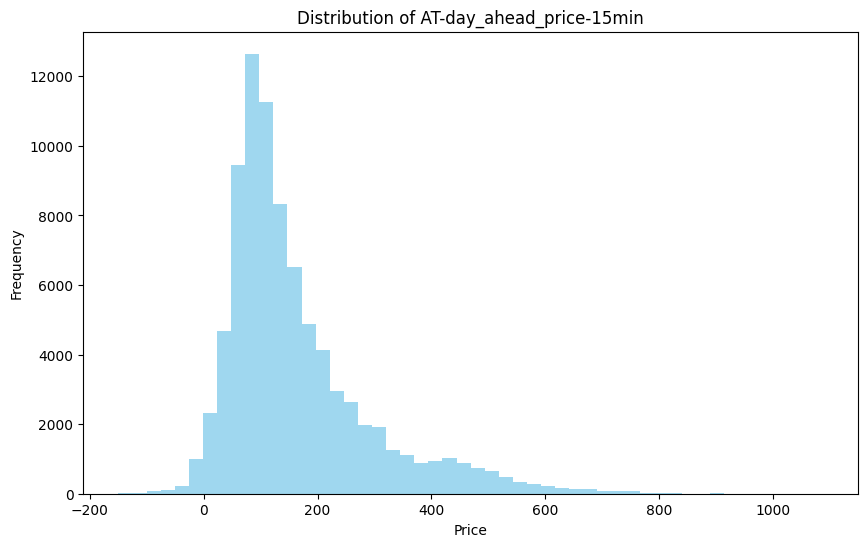


Pearson correlation between AT and DE_LU prices: 0.92
Spearman correlation between AT and DE_LU prices: 0.89


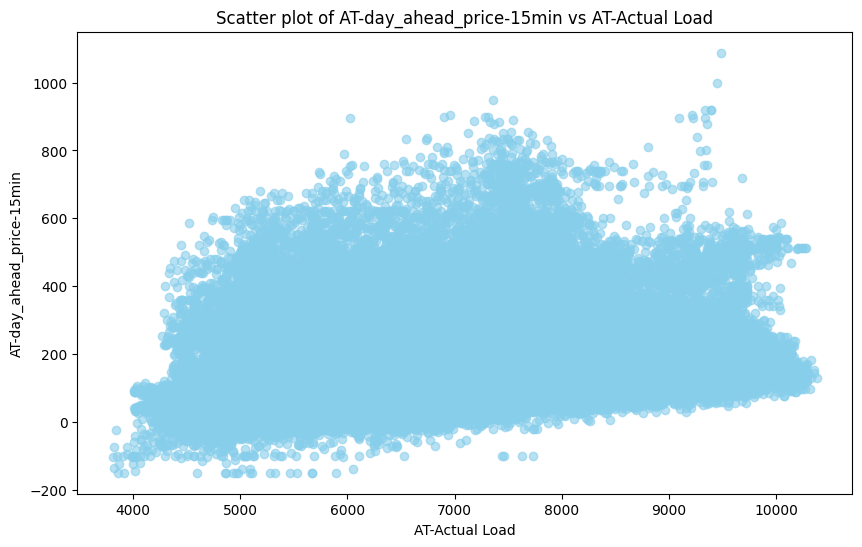

<ipython-input-2-99d485dfa739>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_df.interpolate(method='linear', inplace=True)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
prices_df = pd.read_csv('/content/drive/MyDrive/RA_programming_test/combined_day_ahead_prices.csv', index_col=0)
load_df = pd.read_csv('/content/drive/MyDrive/RA_programming_test/combined_load_actual.csv', index_col=0)

# 检查缺失值百分比
print("Prices DataFrame missing values percentage:")
print(prices_df.isnull().mean() * 100)
print("\nLoad DataFrame missing values percentage:")
print(load_df.isnull().mean() * 100)

# 检查价格特征列的统计信息
print("\nPrices DataFrame statistics:")
print(prices_df.describe())

# 可视化"AT-day_ahead_price-15min"的分布
plt.figure(figsize=(10, 6))
plt.hist(prices_df['AT-day_ahead_price-15min'], bins=50, alpha=0.8, color='skyblue')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of AT-day_ahead_price-15min')
plt.show()

# 计算"AT-day_ahead_price-15min"和"DE_LU-day_ahead_price-15min"之间的皮尔逊和斯皮尔曼相关系数
pearson_corr = prices_df['AT-day_ahead_price-15min'].corr(prices_df['DE_LU-day_ahead_price-15min'], method='pearson')
spearman_corr = prices_df['AT-day_ahead_price-15min'].corr(prices_df['DE_LU-day_ahead_price-15min'], method='spearman')
print(f"\nPearson correlation between AT and DE_LU prices: {pearson_corr:.2f}")
print(f"Spearman correlation between AT and DE_LU prices: {spearman_corr:.2f}")

# 合并预处理后的CSV文件
merged_df = pd.merge(prices_df, load_df, left_index=True, right_index=True, how='inner')
# 可视化"AT-day_ahead_price-15min"和"AT-Actual Load"之间的散点图
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['AT-Actual Load'], merged_df['AT-day_ahead_price-15min'], alpha=0.6, color='skyblue')
plt.xlabel('AT-Actual Load')
plt.ylabel('AT-day_ahead_price-15min')
plt.title('Scatter plot of AT-day_ahead_price-15min vs AT-Actual Load')
plt.show()

# 移除非15分钟分辨率的特征列
prices_df = prices_df.loc[:, prices_df.columns.str.endswith('-15min')]
load_df = load_df.loc[:, load_df.columns.str.endswith('Load')]

# 使用插值填充缺失值
prices_df.interpolate(method='linear', inplace=True)
load_df.interpolate(method='linear', inplace=True)

# 合并预处理后的CSV文件
merged_df = pd.merge(prices_df, load_df, left_index=True, right_index=True)

# 使用最小-最大缩放器缩放数据
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_df)
scaled_df = pd.DataFrame(scaled_data, columns=merged_df.columns, index=merged_df.index)
scaled_df.to_csv('scaled_data.csv')  # 保存缩放后的数据

In [ ]:
import numpy as np

def rolling_window(data, window_size, target_col):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size)].drop(columns=[target_col]).values)
        y.append(data.iloc[i + window_size][target_col])
    return np.array(X), np.array(y)

# 设置滚动窗口大小（时间步长）
window_size = 48

# 选择目标列
target_col = 'AT-day_ahead_price-15min'

# 对缩放后的数据应用滚动窗口函数
X, y = rolling_window(scaled_df, window_size, target_col)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

In [ ]:
!pip install optuna

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import pandas as pd
import numpy as np

# 读取数据
scaled_df = pd.read_csv('scaled_data.csv')
scaled_df['CET_dt'] = pd.to_datetime(scaled_df['CET'].apply(lambda x: x[:-6]), format='%Y-%m-%d %H:%M:%S')
scaled_df.set_index('CET_dt', inplace=True)
scaled_df.drop('CET', axis=1, inplace=True)

# 将字符串日期转换为日期类型
start_train_date, end_train_date = pd.to_datetime('2022-01-01'), pd.to_datetime('2024-01-01')
start_val_date, end_val_date = pd.to_datetime('2024-01-01'), pd.to_datetime('2024-03-01')
start_test_date, end_test_date = pd.to_datetime('2024-03-01'), pd.to_datetime('2024-06-01')

# 划分数据集
train_data = scaled_df[(scaled_df.index >= start_train_date) & (scaled_df.index < end_train_date)]
val_data = scaled_df[(scaled_df.index >= start_val_date) & (scaled_df.index < end_val_date)]
test_data = scaled_df[(scaled_df.index >= start_test_date) & (scaled_df.index < end_test_date)]

# 创建 tf.data.Dataset
def create_dataset(data, window_size, target_col, batch_size):
    X, y = rolling_window(data, window_size, target_col)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_data, window_size, target_col, batch_size=256)
val_dataset = create_dataset(val_data, window_size, target_col, batch_size=256)
test_dataset = create_dataset(test_data, window_size, target_col, batch_size=256)

# 定义模型
def create_model(model_type, num_units, dropout_rate, learning_rate):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(num_units))
    else:
        model.add(SimpleRNN(num_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 定义 Optuna 目标函数
def objective(trial, model_type):
    num_units = trial.suggest_int('num_units', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    model = create_model(model_type, num_units, dropout_rate, learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping], verbose=0)

    val_loss = history.history['val_loss'][-1]
    return val_loss

# 运行 Optuna 优化过程
def optimize_model(model_type):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_type), n_trials=10)

    print(f"Best {model_type.upper()} model hyperparameters:")
    print(study.best_params)

    best_model = create_model(model_type, **study.best_params)
    best_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=0)
    best_model.save(f'best_{model_type}_model.h5')

optimize_model('lstm')
optimize_model('rnn')

# 加载并评估最优模型
def evaluate_model(model_path, X_test, y_test):
    model = load_model(model_path)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return rmse, mae, mape

X_test, y_test = rolling_window(test_data, window_size, target_col)

lstm_rmse, lstm_mae, lstm_mape = evaluate_model('best_lstm_model.h5', X_test, y_test)
rnn_rmse, rnn_mae, rnn_mape = evaluate_model('best_rnn_model.h5', X_test, y_test)

print(f"LSTM model - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.2f}%")
print(f"RNN model - RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}, MAPE: {rnn_mape:.2f}%")

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import optuna
import pandas as pd
import numpy as np
import tensorflow as tf

# 读取数据
scaled_df = pd.read_csv('scaled_data.csv')

print(scaled_df['CET'].dtype)
print(scaled_df['CET'].head())

# 手动解析时间戳并创建新的 datetime64 列
scaled_df['CET_dt'] = scaled_df['CET'].apply(lambda x: pd.to_datetime(x[:-6], format='%Y-%m-%d %H:%M:%S'))

print(scaled_df['CET_dt'].dtype)
print(scaled_df['CET_dt'].head())

# 将新的 datetime64 列设置为索引
scaled_df.set_index('CET_dt', inplace=True)

# 删除原来的 'CET' 列
scaled_df.drop('CET', axis=1, inplace=True)

#将字符串日期转换为日期类型
start_train_date = pd.to_datetime('2022-01-01')
end_train_date = pd.to_datetime('2024-01-01')
start_val_date = pd.to_datetime('2024-01-01')
end_val_date = pd.to_datetime('2024-03-01')
start_test_date = pd.to_datetime('2024-03-01')
end_test_date = pd.to_datetime('2024-06-01')

#划分数据集



# 划分数据集
train_data = scaled_df[(scaled_df.index >= start_train_date) & (scaled_df.index < end_train_date)]
val_data = scaled_df[(scaled_df.index >= start_val_date) & (scaled_df.index < end_val_date)]
test_data = scaled_df[(scaled_df.index >= start_test_date) & (scaled_df.index < end_test_date)]

X_train, y_train = rolling_window(train_data, window_size, target_col)
X_val, y_val = rolling_window(val_data, window_size, target_col)
X_test, y_test = rolling_window(test_data, window_size, target_col)


# 创建tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(256)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(256)

# 定义LSTM模型
def create_lstm_model(num_layers, num_units, dropout_rate, learning_rate):
    with tf.device('/gpu:0'):
        model = Sequential()
        for i in range(num_layers):
            if i == num_layers - 1:
                model.add(LSTM(num_units))
            else:
                model.add(LSTM(num_units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
    return model

# 定义简单RNN模型
def create_rnn_model(num_layers, num_units, dropout_rate, learning_rate):
    with tf.device('/gpu:0'):
        model = Sequential()
        for i in range(num_layers):
            if i == num_layers - 1:
                model.add(SimpleRNN(num_units))
            else:
                model.add(SimpleRNN(num_units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
    return model
# 定义Optuna的目标函数
def objective(trial, model_type):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    if model_type == 'lstm':
        model = create_lstm_model(num_layers, num_units, dropout_rate, learning_rate)
    else:
        model = create_rnn_model(num_layers, num_units, dropout_rate, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[early_stopping], verbose=0)

    val_loss = history.history['val_loss'][-1]
    return val_loss

# 运行Optuna优化过程
def optimize_model(model_type):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_type), n_trials=20)

    print(f"Best {model_type.upper()} model hyperparameters:")
    print(study.best_params)

    best_model = create_lstm_model(**study.best_params) if model_type == 'lstm' else create_rnn_model(**study.best_params)
    best_model.fit(train_dataset, validation_data=val_dataset, epochs=100, verbose=0)
    best_model.save(f'best_{model_type}_model.h5')

optimize_model('lstm')
optimize_model('rnn')



# 加载保存的最优模型
from keras.models import load_model

best_lstm_model = load_model('best_lstm_model.h5')
best_rnn_model = load_model('best_rnn_model.h5')

# 在测试集上评估模型性能
def evaluate_model(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return rmse, mae, mape

lstm_rmse, lstm_mae, lstm_mape = evaluate_model(best_lstm_model)
rnn_rmse, rnn_mae, rnn_mape = evaluate_model(best_rnn_model)

print(f"LSTM model - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.2f}%")
print(f"RNN model - RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}, MAPE: {rnn_mape:.2f}%")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import optuna
import pandas as pd
import numpy as np
import tensorflow as tf

# 读取数据
scaled_df = pd.read_csv('scaled_data.csv')

print(scaled_df['CET'].dtype)
print(scaled_df['CET'].head())

# 手动解析时间戳并创建新的 datetime64 列
scaled_df['CET_dt'] = scaled_df['CET'].apply(lambda x: pd.to_datetime(x[:-6], format='%Y-%m-%d %H:%M:%S'))

print(scaled_df['CET_dt'].dtype)
print(scaled_df['CET_dt'].head())

# 将新的 datetime64 列设置为索引
scaled_df.set_index('CET_dt', inplace=True)

# 删除原来的 'CET' 列
scaled_df.drop('CET', axis=1, inplace=True)

#将字符串日期转换为日期类型
start_train_date = pd.to_datetime('2022-01-01')
end_train_date = pd.to_datetime('2024-01-01')
start_val_date = pd.to_datetime('2024-01-01')
end_val_date = pd.to_datetime('2024-03-01')
start_test_date = pd.to_datetime('2024-03-01')
end_test_date = pd.to_datetime('2024-06-01')

#划分数据集



# 划分数据集
train_data = scaled_df[(scaled_df.index >= start_train_date) & (scaled_df.index < end_train_date)]
val_data = scaled_df[(scaled_df.index >= start_val_date) & (scaled_df.index < end_val_date)]
test_data = scaled_df[(scaled_df.index >= start_test_date) & (scaled_df.index < end_test_date)]

X_train, y_train = rolling_window(train_data, window_size, target_col)
X_val, y_val = rolling_window(val_data, window_size, target_col)
X_test, y_test = rolling_window(test_data, window_size, target_col)


# 定义LSTM模型
def create_lstm_model(num_layers, num_units, dropout_rate, learning_rate):
    with tf.device('/gpu:0'):  # 将模型放置在GPU上
        model = Sequential()
        for i in range(num_layers):
            if i == num_layers - 1:
                model.add(LSTM(num_units))
            else:
                model.add(LSTM(num_units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
    return model

# 定义简单RNN模型
def create_rnn_model(num_layers, num_units, dropout_rate, learning_rate):
    with tf.device('/gpu:0'):  # 将模型放置在GPU上
        model = Sequential()
        for i in range(num_layers):
            if i == num_layers - 1:
                model.add(SimpleRNN(num_units))
            else:
                model.add(SimpleRNN(num_units, return_sequences=True))
            model.add(Dropout(dropout_rate))
        model.add(Dense(1))
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
    return model

# 定义Optuna的目标函数
def objective(trial, model_type):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_units = trial.suggest_int('num_units', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    if model_type == 'lstm':
        model = create_lstm_model(num_layers, num_units, dropout_rate, learning_rate)
    else:
        model = create_rnn_model(num_layers, num_units, dropout_rate, learning_rate)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping], verbose=0)

    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

# 运行Optuna优化过程
def optimize_model(model_type):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_type), n_trials=50)

    print(f"Best {model_type.upper()} model hyperparameters:")
    print(study.best_params)

    best_model = create_lstm_model(**study.best_params) if model_type == 'lstm' else create_rnn_model(**study.best_params)
    best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=64, verbose=0)
    best_model.save(f'best_{model_type}_model.h5')

optimize_model('lstm')
optimize_model('rnn')

# 加载保存的最优模型
from keras.models import load_model

best_lstm_model = load_model('best_lstm_model.h5')
best_rnn_model = load_model('best_rnn_model.h5')

# 在测试集上评估模型性能
def evaluate_model(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    return rmse, mae, mape

lstm_rmse, lstm_mae, lstm_mape = evaluate_model(best_lstm_model)
rnn_rmse, rnn_mae, rnn_mape = evaluate_model(best_rnn_model)

print(f"LSTM model - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.2f}%")
print(f"RNN model - RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}, MAPE: {rnn_mape:.2f}%")